In [1]:
%matplotlib widget

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
from numpy import gradient, squeeze, sqrt
from scipy.integrate import solve_ivp
from matplotlib.widgets import Slider, Button, RadioButtons



In [3]:
df = pd.read_csv("../FittingExperiments/Data/Grim/data.csv")
df['time'] = df['timestamp (ms)'].map(lambda ms : ms / 1000)
df.set_index('time', inplace=True)

def rrc3_pressure_conversion_function_ft(press_kpa):
    pressure = press_kpa * 10
    altitude = (1 - pow(pressure / 1_013.25, 0.190284)) * 145_366.45
    return altitude


def ft_to_meters(ft): return ft * 0.3048
boost_end = 3_500
first_charge = 28_125
altim = df[['pressure (kPa)']].copy()
altim['alt_m_asl'] = altim['pressure (kPa)'].map(rrc3_pressure_conversion_function_ft).map(ft_to_meters)
altim['alt_m_agl'] = altim['alt_m_asl'] - altim['alt_m_asl'].min()

In [4]:
altim

,pressure (kPa),alt_m_asl,alt_m_agl
time,,,
0.268,86.639748,1300.615322,8.387588
0.272,86.639748,1300.615322,8.387588
0.275,86.728584,1292.227734,0.000000
0.279,86.728584,1292.227734,0.000000
0.282,86.728584,1292.227734,0.000000
...,...,...,...
400.251,86.514793,1312.424773,20.197039
400.255,86.514793,1312.424773,20.197039
400.258,86.514793,1312.424773,20.197039


In [5]:
data = altim.loc[boost_end/1000:first_charge/1000]
data.index = data.index - data.index.min()

In [6]:


def f(pos, vel, ts, g, b, m):
    mb = b / m
    F = g - mb * vel * vel
    nextvel = vel + (F / m) * ts
    nextpos = pos + ts * vel
    return nextpos, nextvel


def integrate(f, x_0, v_0, g, b, m, tmax, ts):
    positions,velocities = [x_0], [v_0]
    t = [0]
    for i in range(int(tmax / ts)):
        p, v = f(positions[-1], velocities[-1], ts, g, b, m)
        positions.append(p)
        velocities.append(v)
        t.append(t[-1] + ts)
    return positions, velocities, t

In [7]:
g = -9.86
b = 0.01
m = 3.927
v_0 = 426
x_0 = data.alt_m_agl.min() 

tmax = 28
ts = 0.05

positions, velocities, t = integrate(f, x_0, v_0, g, b, m, tmax, ts)

In [8]:
start = data.iloc[0:100]
dy = start.alt_m_agl.max() - start.alt_m_agl.min()
dt = start.index.max() - start.index.min()
vel = dy / dt

In [9]:
vel

np.float64(426.1254283006279)

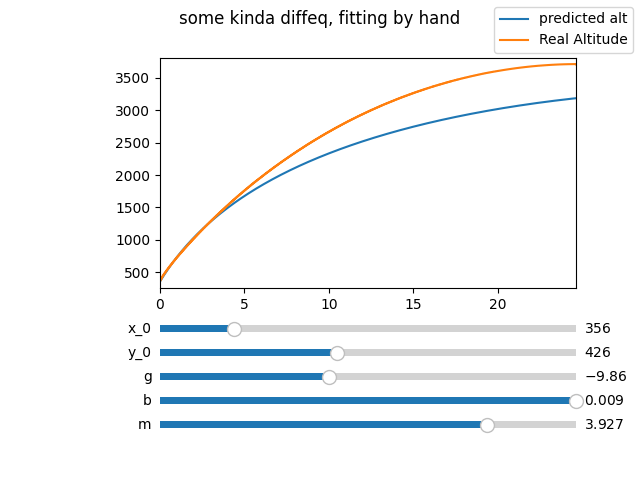

In [10]:
plt.close()
fig = plt.figure()
ax = fig.add_subplot(111)

# Adjust the subplots region to leave some space for the sliders and buttons
fig.subplots_adjust(left=0.25, bottom=0.4)

[pred_alt] = ax.plot(t, positions, label = 'predicted alt')

# fig.plot(t, velocities, label = "vel")
ax.plot(data.index, data['alt_m_agl'], label = "Real Altitude")

ax.set_xlim(data.index.min(), data.index.max())
ax.set_ylim(data['alt_m_agl'].min()-100, data['alt_m_agl'].max()+100)
fig.suptitle("some kinda diffeq, fitting by hand")

x0_slider_ax  = fig.add_axes([0.25, 0.3, 0.65, 0.03])
x0_slider = Slider(x0_slider_ax, 'x_0', 0.0, 2000.0, valinit=x_0)

v0_slider_ax = fig.add_axes([0.25, 0.25, 0.65, 0.03])
v0_slider = Slider(v0_slider_ax, 'y_0', 0.0, 1000.0, valinit=v_0)

g_slider_ax = fig.add_axes([0.25, 0.2, 0.65, 0.03])
g_slider = Slider(g_slider_ax, 'g', -20.0, 5.0, valinit=g)

b_slider_ax = fig.add_axes([0.25, 0.15, 0.65, 0.03])
b_slider = Slider(b_slider_ax, 'b', 0.0, 0.009, valinit=b)

m_slider_ax = fig.add_axes([0.25, 0.1, 0.65, 0.03])
m_slider = Slider(m_slider_ax, 'm', 0.0, 5.0, valinit=m)


def sliders_on_changed(val):
    
    ps, vs, times = integrate(f, x0_slider.val, v0_slider.val, g_slider.val, b_slider.val, m_slider.val, tmax, ts)
    pred_alt.set_ydata(ps)
    # line.
    fig.canvas.draw_idle()
x0_slider.on_changed(sliders_on_changed)
v0_slider.on_changed(sliders_on_changed)
g_slider.on_changed(sliders_on_changed)
b_slider.on_changed(sliders_on_changed)
m_slider.on_changed(sliders_on_changed)



fig.legend()
plt.show()

In [11]:
# plt.close()